# "Will the SP-500 fall to index X by date Y"
> "a baseline forecast using python"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Tassilo Neubauer
- categories: [prediction, python]

I occasionally make predictions on the forecasting Site Almanis. Some monthly recurring questions there are of the format: "By date_X, will the S&P 500 fall below Index_Y?"

To get a baseline for my predictions on those questions, I made this notebook. Feel free to download it for your own predictions. You can download or execute it online with Google Colab. Here is a link to the S&P 500 CSV-file which I originally downloaded from Yahoo Finance.

For this example, I will ask the question: "Will the S&P 500 go above 3900 by February 1st, 2021?"

In this model we assume the SP 500 to be a random walk which means there is no correlation between the price changes between days. This is not entirely true. But is good enough for the rough model we are aiming for here. Since changes in a random walk are independent of each other, the only information that we have about the future index is where the index stands right now. So when we want to answer the question of whether the S&P 500 will exceed a certain index, we will look at the difference between the current index (3824,7) and the index that we want to know the probability of exceedance for (3900). We compute this probability by looking at the frequency at which this happened in the past{% fn 1 %}.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics as stg #we are going to use this later on to check our timeseries for autocorrelation
import statsmodels.api as sm
%matplotlib inline

df = pd.read_csv("https://raw.githubusercontent.com/sonofhypnos/projects/master/_notebooks/%5EGSPC.csv")


So before we can answer our initial question, we take a quick look at our data.

In [2]:
days_ahead = 22 # the number of days that the S&P has to stay within the boundary
boundary = 3900

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


As we can see this dataset goes back until 1927 which is pretty great for a free dataset. Another thing to notice here is that we only have data for the S&P 500 on business days. Since this is only supposed to be a rough baseline forecast, we are going to ignore this fact and just pretend that the difference between Friday and Monday will be the same as between Tuesday and Wednesday. But we will still have to keep this fact in mind, so that our forecast also only includes workdays.

In [4]:
sp = df.Close
sp.index = pd.to_datetime(df.Date)

In [5]:
sp.head()

Date
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
Name: Close, dtype: float64

Let's take a first look at our timeseries

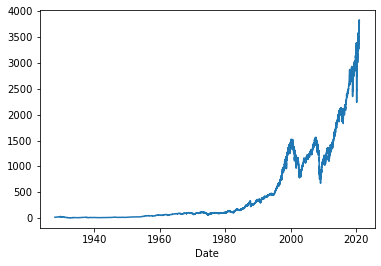

In [6]:
sns.lineplot(x=sp.index, y=sp.values);

As you can see the graph is growing exponentially. This is even more clear on a log scale:

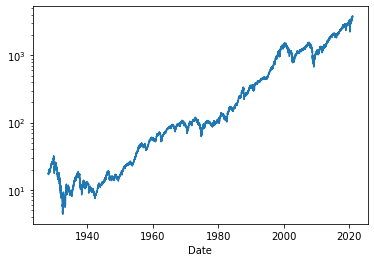

In [7]:
sns.lineplot(x=sp.index, y=sp.values)
plt.yscale("log")

We now take a closer look at the correlation in our graph. If this is a random, then there shouldn't be any correlation between price changes and this is indeed what we see:

In [13]:
#computing pricechanges
sp_shifted = sp - sp.shift()

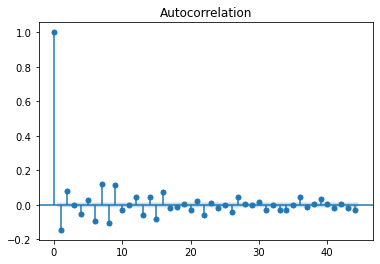

In [14]:
stg.tsaplots.plot_acf(sp_shifted[1:])
plt.show()

The following function computes the relative difference between different days in the past.

In [15]:
def relative_shift_n(ts, n):
    ts_shift = []
    for i in range(1,n+1):
        ts_shift.append((ts - ts.shift(periods=i))/ts)
    return ts_shift

Now we compute the number of workdays ahead for our forecast

In [16]:
current_weekday = sp[-1:].index.weekday[0] + 1
days_ahead = 15
n = 0

for i in range(days_ahead):
    if (current_weekday % 7) < 5:
        n += 1
    current_weekday += 1
print("workdays ahead:", n)

workdays ahead: 10


In [17]:
sp_shift = relative_shift_n(sp, n)
shift_index = [str(x) for x in range(1,n+1)]
sp_shift = pd.DataFrame.from_dict(dict(zip(shift_index,sp_shift)))
sp_shift = sp_shift[n:] #removing NaN entries

`sp_shift` is an array of price-changes for different intervalls. The title of each column corresponds to the number of days between which the price change was computed. 

In [20]:
sp_shift

,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,
1928-01-16,-0.016773,-0.010411,-0.003470,-0.004627,-0.012146,-0.021400,-0.015037,-0.024870,-0.027183,-0.021400
1928-01-17,0.000578,-0.016185,-0.009827,-0.002890,-0.004046,-0.011561,-0.020809,-0.014451,-0.024277,-0.026590
1928-01-18,-0.002317,-0.001738,-0.018540,-0.012167,-0.005214,-0.006373,-0.013905,-0.023175,-0.016802,-0.026651
1928-01-19,0.006904,0.004603,0.005178,-0.011508,-0.005178,0.001726,0.000575,-0.006905,-0.016111,-0.009781
1928-01-20,0.005721,0.012586,0.010298,0.010870,-0.005721,0.000572,0.007437,0.006293,-0.001144,-0.010297
...,...,...,...,...,...,...,...,...,...,...
2021-01-04,-0.014976,-0.008482,-0.007131,-0.009379,-0.000651,0.002875,0.003618,0.001548,-0.002367,-0.005899
2021-01-05,0.007033,-0.007838,-0.001390,-0.000048,-0.002281,0.006386,0.009888,0.010626,0.008570,0.004682
2021-01-06,0.005677,0.012670,-0.002116,0.004295,0.005629,0.003410,0.012027,0.015509,0.016243,0.014199


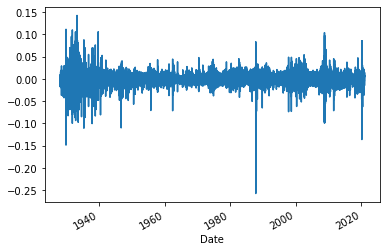

In [21]:
sp_shift["1"].plot();

The following function finally computes the probability of this happening.

probability of going above boundary:
0.44183756475574776


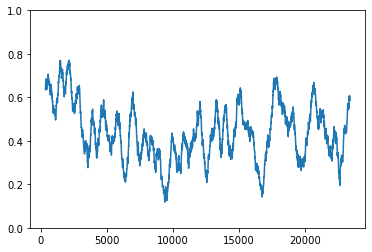

In [23]:
sp_forecast = float(sp[-1:]) + sp_shift * float(sp[-1:])

beyond_boundary = []
#change beyond boundary list based on whether our boundry is 
#above or below the current index of the S&P 500
if float(sp[-1:]) < boundary:
    print("probability of going above boundary:")
    for i in range(len(sp_forecast)):
        beyond_boundary.append(any(sp_forecast.iloc[i] > boundary)) 
else:
    print("probability of going below boundary:")
    for i in range(len(sp_forecast)):
        beyond_boundary.append(any(sp_forecast.iloc[i] < boundary))

beyond_boundary = pd.Series(beyond_boundary)

print(beyond_boundary.mean())

beyond_boundary.rolling(window=365).mean().plot()
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

As we can see the 

{{ 'To be precise, I computed the size of the gap between the current index and the boundary index (3900) as a percentage of the absolute index. I then looked at how often such a big gap had been exceeded in the past in the same number of days.' | fndetail: 1 }}  